In [1]:
from yoloexplorer import Explorer

In [2]:
voc_exp = Explorer("VOC.yaml") # use coco128.yaml for trying out

Ultralytics YOLOv8.0.120 🚀 Python-3.11.4 torch-2.0.1 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients


In [3]:
voc_exp.build_embeddings()

Scanning /Users/ayushchaurasia/Documents/ultralytics/datasets/VOC/labels/train2007.cache... 16551 images, 0 backgrounds, 0 corrupt: 100%|███
LanceDB embedding space already exists. Attempting to reuse it. Use force=True to overwrite.


In [9]:
table = voc_exp.table # Get LanceDB table
len(table) # Total Dataset size
print(table.schema) # Table Schema
table.to_pandas().head()["path"].to_list() # get the path of first 5 images

id: int64
path: string
cls: list<item: int64>
  child 0, item: int64
labels: list<item: string>
  child 0, item: string
bboxes: list<item: list<item: double>>
  child 0, item: list<item: double>
      child 0, item: double
img: binary
vector: fixed_size_list<item: float>[1024]
  child 0, item: float


['/Users/ayushchaurasia/Documents/ultralytics/datasets/VOC/images/train2007/000012.jpg',
 '/Users/ayushchaurasia/Documents/ultralytics/datasets/VOC/images/train2007/000017.jpg',
 '/Users/ayushchaurasia/Documents/ultralytics/datasets/VOC/images/train2007/000023.jpg',
 '/Users/ayushchaurasia/Documents/ultralytics/datasets/VOC/images/train2007/000026.jpg',
 '/Users/ayushchaurasia/Documents/ultralytics/datasets/VOC/images/train2007/000032.jpg']

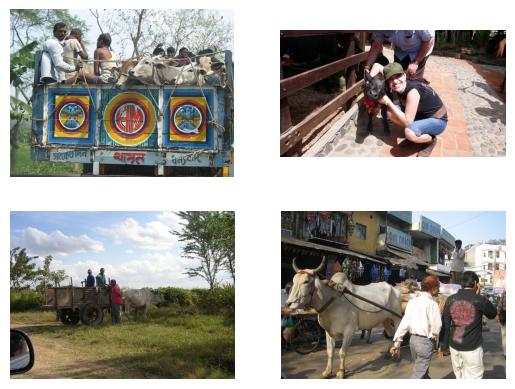

In [17]:
query = "SELECT * from 'table' WHERE labels like '%person%' and labels like '%cow%'"
voc_exp.plot_imgs(query=query, n=4, labels=False)

In [7]:
voc_exp.dataset_info["names"]

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

In [22]:
# run queries and get dataframes
query = "SELECT id from 'table' WHERE labels like '%person, person, person%' and labels like '%cow%'"
voc_exp.sql(query)
#exp.sql(query)["id"].to_list()

,id
0,6472
1,7287
2,8821
3,9225
4,12695
5,15001
6,15601


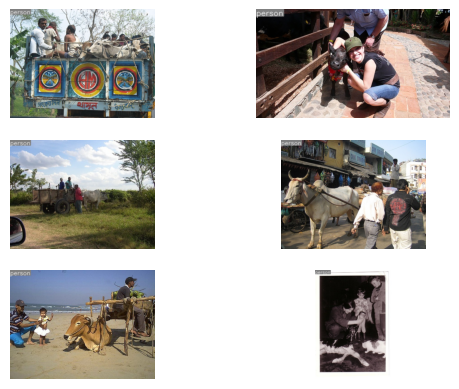

In [21]:
voc_exp.plot_imgs([6472, 7287, 8821, 9225, 12695, 15001, 15601])

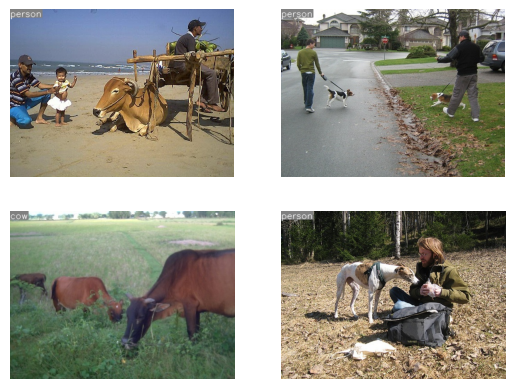

In [27]:
voc_exp.plot_similar_imgs(12695, n=5) # Coming soon -> plot_similar_imgs(..., filer="WHERE labels like %...%")

### Coming Soon, pre-filtering
* To allow adding filter to searches.
* Have a finer control over embeddings search space

Pre-filtering will enable powerful queries like - "Show me images similar to <IMAGE> and include only ones that contain one or more(or exactly one) person, 2 cars and 1 horse"

In [29]:
coco_exp = Explorer("coco128.yaml", model="yolov8n.pt")
coco_exp.build_embeddings(force=True) # don't reuse old embeddings

Ultralytics YOLOv8.0.120 🚀 Python-3.11.4 torch-2.0.1 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients
Scanning /Users/ayushchaurasia/Documents/ultralytics/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|█


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.10it/s]
LanceDB: Embedding space built successfully.


### Enrich dataset
get an image from VOC dataset that the model gets confused on, and add similar examples from coco dataset to hopefully improve performance/ increase confidence for predictions in more such scenarios

Use case:
* When model simply suffers in a particular environment
* When model has low accuracy scores for particular classes
* To enrich the model with relevant data during data drift

In [39]:
# assume id 12695 as a bad example
df = voc_exp.table.to_pandas()
img_12695 = df["img"][12695] # Same as voc_exp.table.to_pandas()["path"][12695]

# find 5 similar imgs in COCO dataset
imgs, ids = coco_exp.get_similar_imgs(img_12695)
print(ids)

image0.jpg


[13, 63, 75, 54, 101, 91, 106, 55, 77, 111]


image0.jpg


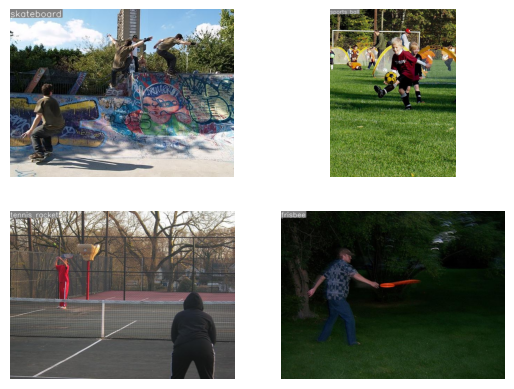

In [40]:
# view them
# voc_exp.plot_imgs([12695]) # Fix this
coco_exp.plot_similar_imgs(img_12695, n=5) # Coming soon pre-filtering

In [41]:
# add them to VOC
voc_exp.add_imgs(coco_exp, idxs=[13, 63, 75, 54, 101, 91, 106, 55, 77, 111])


|-----------------------------------------------|
	 Number of images: 16561
|------------------------------------------------|


In [42]:
# Persist changes to create a new dataset
voc_exp.persist(name="voc_updated") # Optionally excepts name for new dataset 

Persisting changes to the dataset...

|-----------------------------------------------|
	 Number of images: 16561
|------------------------------------------------|
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16561/16561 [00:00<00:00, 39772.34it/s]
Changes persisted to the dataset.
LanceDB: New dataset created successfully! Run the following command to train a model:
yolo train data=run/voc_updated epochs=10


### That's it! Now you have a new trainable dataset


In [45]:
# train a model on the new 
!yolo train data="voc_updated/voc_updated.yaml"
# ignore warnings. This is normal as we're mixing dataset with different class numbers (Out of Domain data)

WARNING ⚠️ 'model' is missing. Using default 'model=yolov8n.pt'.
New https://pypi.org/project/ultralytics/8.0.132 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.120 🚀 Python-3.11.4 torch-2.0.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=voc_updated/voc_updated.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=Fa

### What if I want to get rid of some bad data
There are many sitautions where some OOD data point might disturb model training and hence its performance. You can get rid of any data by simply passing thier ids.
HINT: you can combine it with similarity search and sql pre-filtering(coming soon) to get similar bad examples to remove

In [50]:
# Let's assume you found these 7 idxs are similar to bad image -> [50, 400, 1256, 2000, 2500, 10000, 11050]
print("Original len ", len(voc_exp.table))
voc_exp.remove_imgs([50, 400, 1256, 2000, 2500, 10000, 11050])

Original len  16561



|-----------------------------------------------|
	 Number of images: 16554
|------------------------------------------------|


In [51]:
# persist to create a new trainable dataset